# Survival analysis para la empresa JAMPP - Notebook dedicado al fit con Cox

El objetivo es analizar los datos de la empresa JAMPP para saber cuando un usuario volverá a conectarse a una app, dado sus datos de conexiones previas. La segunda predicción que intentaremos hacer es saber cuando volverá a "convertir", es decir comprar la app de la cual tiene una publicidad en su movil a un momento dado.



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lifelines
import category_encoders as ce

In [2]:
events = pd.read_csv('./events.csv')

/Users/yorickvinesse/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
clicks = pd.read_csv('./clicks.csv')

/Users/yorickvinesse/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
installs = pd.read_csv('./installs.csv')

/Users/yorickvinesse/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Que datos nos conviene usar?

Acá estamos haciendo un _survival analysis_ entonces se necesita mostrar el momento al cual ocurrió un evento. En nuestro caso, si un evento aparece en el dataset de _auctions_, es porque ocurrió. El survival analysis se enfoca en la primera vez que ocurre un evento, puesto que hace una regresión de un set de caractéristicas en frente a una fecha de ocurrencia del evento.

Pero es cierto que muchos usuarios, aca representados por sus *device_id* aparecen varias veces en la lista de subastas (_auctions_), considerando que 475338 *device_id* únicos se pueden contar adentro del set de _auctions_ que almacena 47409528 observaciones distintas (100 veces más).

Dado eso, parecería inoportuno no considerar la característica de repetición de aparición de los usuarios cuando hacemos la predicción de su reaparición más adelante.

Podemos tratar de analizar datos como la cantidad de clicks hecha por un usuario antes de llevar a cabo una instalación, o la cantidad de veces que apareció en una subasta.

### Para aliviar los sets, sacamos las columnas que llevan el mismo valor para todas filas.

In [5]:
events.drop(columns = ['device_countrycode'], inplace = True)
clicks.drop(columns = ['country_code'], inplace = True)
installs.drop(columns = ['device_countrycode'], inplace = True)

## Análisis de los eventos y installs para tratar de predecir con un modelo de Cox.

Se debe tratar de predecir cuales features nos van a interesar en el fit. El tipo de conexión, por ejemplo, servirá mucho, mientras el countrycode no (solo hay uno en el set de datos).

In [108]:
events.count()

index                 7744581
date                  7744581
event_id              7744581
ref_type              7744581
ref_hash              7744581
application_id        7744581
attributed            7744581
device_os_version     2332975
device_brand          2553424
device_model          5668092
device_city           1894935
session_user_agent    7702301
trans_id                37642
user_agent            3341483
event_uuid            7714809
carrier               1925901
kind                  7714809
device_os             1870190
wifi                  7744581
connection_type       1809296
ip_address            7744581
device_language       5665409
dtype: int64

In [6]:
eventsCurated = events.drop(columns = ['ref_type', 'session_user_agent', 'device_os_version', 'device_brand',\
                                       'device_model', 'trans_id', 'user_agent', 'ip_address'])

In [7]:
eventsCurated.head(2)

,index,date,event_id,ref_hash,application_id,attributed,device_city,event_uuid,carrier,kind,device_os,wifi,connection_type,device_language
0,2130678,2019-04-20 01:42:49.120,0,5857744372586891366,210,False,NaN,5b506964-5f47-4b28-a8c2-8a92d6c23379,NaN,5.882882e+18,NaN,False,NaN,3.301378e+18
1,2130680,2019-04-20 01:42:49.340,1,7642521036780133571,210,False,NaN,f1fb9d15-1a7b-4116-8d3b-c4c403e197e2,NaN,4.017674e+18,NaN,False,NaN,NaN


## Vamos a curar los features de installs ahora, dejar todas las columnas que ya aparecen en _events_ y despues empezar a mergear los dos dataframes, antes de separarlos en ventanas de tres días.

In [125]:
installs.count()

created               481511
application_id        481511
ref_type              481511
ref_hash              481511
click_hash              1142
attributed            481511
implicit              481511
device_brand          276443
device_model          454619
session_user_agent    466672
user_agent            330768
event_uuid            103168
kind                  103168
wifi                  294829
trans_id                8933
ip_address            481511
device_language       453934
dtype: int64

In [8]:
installsCurated = installs.drop(columns = ['created', 'application_id', 'ref_type', 'ref_hash', \
                                           'click_hash', 'attributed', 'device_brand', 'device_model',\
                                           'session_user_agent', 'user_agent', 'kind', 'wifi', 'trans_id',\
                                          'ip_address', 'device_language'])

### Nos quedamos con los implicit = True, para solo analizar los installs de los cuales tenemos el evento registrado.

In [9]:
installsCurated = installsCurated[installsCurated.implicit]

In [10]:
installsCurated['installed'] = 1

In [11]:
installsCurated.head(2)

,implicit,event_uuid,installed
0,True,79837499-2f2a-4605-a663-e322f759424f,1
2,True,dda99e3c-9c4b-487d-891c-79f0a02cb4a8,1


In [12]:
eventsAndInstallsCurated = pd.merge(eventsCurated, installsCurated, on = 'event_uuid', how = 'left')

In [11]:
eventsAndInstallsCurated.count()

index                   7744666
date                    7744666
event_id                7744666
ref_hash                7744666
application_id          7744666
attributed              7744666
device_countrycode_x    7744666
device_city             1895020
event_uuid              7714894
carrier                 1925986
kind                    7714894
device_os               1870190
wifi                    7744666
connection_type         1809296
device_language         5665494
implicit                 102359
device_countrycode_y     102359
installed                102359
dtype: int64

In [13]:
eventsAndInstallsCurated = eventsAndInstallsCurated.drop(columns = ['implicit'])

### Aca llenamos la columna de _installed_ con 0 en los eventos que no llevan a una instalacion. Eso sera la columna indicando el _censorship_ para nuestro modelo Cox

In [14]:
eventsAndInstallsCurated[['installed']] = eventsAndInstallsCurated[['installed']].fillna(value = 0)

In [16]:
eventsAndInstallsCurated.count()

index              7744666
date               7744666
event_id           7744666
ref_hash           7744666
application_id     7744666
attributed         7744666
device_city        1895020
event_uuid         7714894
carrier            1925986
kind               7714894
device_os          1870190
wifi               7744666
connection_type    1809296
device_language    5665494
installed          7744666
dtype: int64

# Separacion por ventana, para no tratar con sets de datos enormes. Asi empezamos las pruebas y si nos anda bien, podemos hacerlo con todo.

In [15]:
eventsInstallsVentanaUno = eventsAndInstallsCurated.loc[(eventsAndInstallsCurated['date'] < "2019-04-21")]
eventsInstallsVentanaUno = eventsInstallsVentanaUno.loc[(eventsAndInstallsCurated['date'] > "2019-04-18")]

In [16]:
eventsInstallsVentanaDos = eventsAndInstallsCurated.loc[(eventsAndInstallsCurated['date'] < "2019-04-22")]
eventsInstallsVentanaDos = eventsInstallsVentanaDos.loc[(eventsAndInstallsCurated['date'] > "2019-04-19")]

In [17]:
eventsInstallsVentanaTres = eventsAndInstallsCurated.loc[(eventsAndInstallsCurated['date'] < "2019-04-23")]
eventsInstallsVentanaTres = eventsInstallsVentanaTres.loc[(eventsAndInstallsCurated['date'] > "2019-04-20")]

In [18]:
eventsInstallsVentanaCuatro = eventsAndInstallsCurated.loc[(eventsAndInstallsCurated['date'] < "2019-04-24")]
eventsInstallsVentanaCuatro = eventsInstallsVentanaCuatro.loc[(eventsAndInstallsCurated['date'] > "2019-04-21")]

In [19]:
eventsInstallsVentanaCinco = eventsAndInstallsCurated.loc[(eventsAndInstallsCurated['date'] < "2019-04-25")]
eventsInstallsVentanaCinco = eventsInstallsVentanaCinco.loc[(eventsAndInstallsCurated['date'] > "2019-04-22")]

### Tratamos de ver que importancia tiene el uso del wifi en la instalación de apps. Damos a cada device_id como feature su promedio de uso del wifi en los eventos en los cuales participó. 

### Hacemos pruebas con la ventana uno.

In [20]:
proporcionWifiPorDeviceVentanaUno = eventsInstallsVentanaUno[['ref_hash', 'wifi']].groupby('ref_hash').mean()
proporcionWifiPorDeviceVentanaDos = eventsInstallsVentanaDos[['ref_hash', 'wifi']].groupby('ref_hash').mean()
proporcionWifiPorDeviceVentanaTres = eventsInstallsVentanaTres[['ref_hash', 'wifi']].groupby('ref_hash').mean()
proporcionWifiPorDeviceVentanaCuatro = eventsInstallsVentanaCuatro[['ref_hash', 'wifi']].groupby('ref_hash').mean()
proporcionWifiPorDeviceVentanaCinco = eventsInstallsVentanaCinco[['ref_hash', 'wifi']].groupby('ref_hash').mean()

In [21]:
proporcionWifiPorDeviceVentanaUno.head(2)

,wifi
ref_hash,
41863526108385,0.0
161514654074162,1.0


In [22]:
proporcionWifiPorDeviceVentanaUno = proporcionWifiPorDeviceVentanaUno.stack().reset_index()
proporcionWifiPorDeviceVentanaDos = proporcionWifiPorDeviceVentanaDos.stack().reset_index()
proporcionWifiPorDeviceVentanaTres = proporcionWifiPorDeviceVentanaTres.stack().reset_index()
proporcionWifiPorDeviceVentanaCuatro = proporcionWifiPorDeviceVentanaCuatro.stack().reset_index()
proporcionWifiPorDeviceVentanaCinco = proporcionWifiPorDeviceVentanaCinco.stack().reset_index()

In [23]:
proporcionWifiPorDeviceVentanaUno = proporcionWifiPorDeviceVentanaUno.drop(columns = ['level_1'])
proporcionWifiPorDeviceVentanaDos = proporcionWifiPorDeviceVentanaDos.drop(columns = ['level_1'])
proporcionWifiPorDeviceVentanaTres = proporcionWifiPorDeviceVentanaTres.drop(columns = ['level_1'])
proporcionWifiPorDeviceVentanaCuatro = proporcionWifiPorDeviceVentanaCuatro.drop(columns = ['level_1'])
proporcionWifiPorDeviceVentanaCinco = proporcionWifiPorDeviceVentanaCinco.drop(columns = ['level_1'])

In [24]:
proporcionWifiPorDeviceVentanaUno.columns = ['ref_hash', 'proporcion_wifi']
proporcionWifiPorDeviceVentanaDos.columns = ['ref_hash', 'proporcion_wifi']
proporcionWifiPorDeviceVentanaTres.columns = ['ref_hash', 'proporcion_wifi']
proporcionWifiPorDeviceVentanaCuatro.columns = ['ref_hash', 'proporcion_wifi']
proporcionWifiPorDeviceVentanaCinco.columns = ['ref_hash', 'proporcion_wifi']

### Nos queremos quedar con un porcentaje, mas legible.

In [25]:
proporcionWifiPorDeviceVentanaUno['proporcion_wifi'] = proporcionWifiPorDeviceVentanaUno['proporcion_wifi']*100
proporcionWifiPorDeviceVentanaDos['proporcion_wifi'] = proporcionWifiPorDeviceVentanaDos['proporcion_wifi']*100
proporcionWifiPorDeviceVentanaTres['proporcion_wifi'] = proporcionWifiPorDeviceVentanaTres['proporcion_wifi']*100
proporcionWifiPorDeviceVentanaCuatro['proporcion_wifi'] = proporcionWifiPorDeviceVentanaCuatro['proporcion_wifi']*100
proporcionWifiPorDeviceVentanaCinco['proporcion_wifi'] = proporcionWifiPorDeviceVentanaCinco['proporcion_wifi']*100

In [26]:
proporcionWifiPorDeviceVentanaUno.head(2)

,ref_hash,proporcion_wifi
0,41863526108385,0.0
1,161514654074162,100.0


In [27]:
eventsInstallsVentanaUno = pd.merge(eventsInstallsVentanaUno, proporcionWifiPorDeviceVentanaUno,\
                                    on = "ref_hash", how = "left")
eventsInstallsVentanaDos = pd.merge(eventsInstallsVentanaDos, proporcionWifiPorDeviceVentanaDos,\
                                    on = "ref_hash", how = "left")
eventsInstallsVentanaTres = pd.merge(eventsInstallsVentanaTres, proporcionWifiPorDeviceVentanaTres,\
                                    on = "ref_hash", how = "left")
eventsInstallsVentanaCuatro = pd.merge(eventsInstallsVentanaCuatro, proporcionWifiPorDeviceVentanaCuatro,\
                                    on = "ref_hash", how = "left")
eventsInstallsVentanaCinco = pd.merge(eventsInstallsVentanaCinco, proporcionWifiPorDeviceVentanaCinco,\
                                    on = "ref_hash", how = "left")

In [28]:
eventsInstallsVentanaUno.head(2)

,index,date,event_id,ref_hash,application_id,attributed,device_city,event_uuid,carrier,kind,device_os,wifi,connection_type,device_language,installed,proporcion_wifi
0,2130678,2019-04-20 01:42:49.120,0,5857744372586891366,210,False,NaN,5b506964-5f47-4b28-a8c2-8a92d6c23379,NaN,5.882882e+18,NaN,False,NaN,3.301378e+18,0.0,0.0
1,2130680,2019-04-20 01:42:49.340,1,7642521036780133571,210,False,NaN,f1fb9d15-1a7b-4116-8d3b-c4c403e197e2,NaN,4.017674e+18,NaN,False,NaN,NaN,0.0,0.0


## Tratamiento de la fecha y de la forma del tiempo.

In [29]:
eventsInstallsVentanaUno['fechaInicial'] = pd.to_datetime("2019-04-18 00:00:00")
eventsInstallsVentanaDos['fechaInicial'] = pd.to_datetime("2019-04-19 00:00:00")
eventsInstallsVentanaTres['fechaInicial'] = pd.to_datetime("2019-04-20 00:00:00")
eventsInstallsVentanaCuatro['fechaInicial'] = pd.to_datetime("2019-04-21 00:00:00")
eventsInstallsVentanaCinco['fechaInicial'] = pd.to_datetime("2019-04-22 00:00:00")

In [30]:
eventsInstallsVentanaUno["sum"] = 1
eventsInstallsVentanaDos["sum"] = 1
eventsInstallsVentanaTres["sum"] = 1
eventsInstallsVentanaCuatro["sum"] = 1
eventsInstallsVentanaCinco["sum"] = 1

In [31]:
eventsInstallsVentanaUno.loc[:,'date'] = pd.to_datetime(eventsInstallsVentanaUno['date'], errors = 'coerce')
eventsInstallsVentanaDos.loc[:,'date'] = pd.to_datetime(eventsInstallsVentanaDos['date'], errors = 'coerce')
eventsInstallsVentanaTres.loc[:,'date'] = pd.to_datetime(eventsInstallsVentanaTres['date'], errors = 'coerce')
eventsInstallsVentanaCuatro.loc[:,'date'] = pd.to_datetime(eventsInstallsVentanaCuatro['date'], errors = 'coerce')
eventsInstallsVentanaCinco.loc[:,'date'] = pd.to_datetime(eventsInstallsVentanaCinco['date'], errors = 'coerce')

In [32]:
eventsInstallsVentanaUno["date"] = eventsInstallsVentanaUno["date"] - eventsInstallsVentanaUno["fechaInicial"]
eventsInstallsVentanaDos["date"] = eventsInstallsVentanaDos["date"] - eventsInstallsVentanaDos["fechaInicial"]
eventsInstallsVentanaTres["date"] = eventsInstallsVentanaTres["date"] - eventsInstallsVentanaTres["fechaInicial"]
eventsInstallsVentanaCuatro["date"] = eventsInstallsVentanaCuatro["date"] - eventsInstallsVentanaCuatro["fechaInicial"]
eventsInstallsVentanaCinco["date"] = eventsInstallsVentanaCinco["date"] - eventsInstallsVentanaCinco["fechaInicial"]

In [33]:
eventsInstallsVentanaUno.head(2)

,index,date,event_id,ref_hash,application_id,attributed,device_city,event_uuid,carrier,kind,device_os,wifi,connection_type,device_language,installed,proporcion_wifi,fechaInicial,sum
0,2130678,2 days 01:42:49.120000,0,5857744372586891366,210,False,NaN,5b506964-5f47-4b28-a8c2-8a92d6c23379,NaN,5.882882e+18,NaN,False,NaN,3.301378e+18,0.0,0.0,2019-04-18,1
1,2130680,2 days 01:42:49.340000,1,7642521036780133571,210,False,NaN,f1fb9d15-1a7b-4116-8d3b-c4c403e197e2,NaN,4.017674e+18,NaN,False,NaN,NaN,0.0,0.0,2019-04-18,1


### Convertimos el tiempo en cantidad de segundos.

In [34]:
eventsInstallsVentanaUno["date"] = eventsInstallsVentanaUno["date"].dt.total_seconds()
eventsInstallsVentanaDos["date"] = eventsInstallsVentanaDos["date"].dt.total_seconds()
eventsInstallsVentanaTres["date"] = eventsInstallsVentanaTres["date"].dt.total_seconds()
eventsInstallsVentanaCuatro["date"] = eventsInstallsVentanaCuatro["date"].dt.total_seconds()
eventsInstallsVentanaCinco["date"] = eventsInstallsVentanaCinco["date"].dt.total_seconds()

### Ya no necesitamos la fecha inicial

In [35]:
eventsInstallsVentanaUno = eventsInstallsVentanaUno.drop(columns = ['fechaInicial'])
eventsInstallsVentanaDos = eventsInstallsVentanaDos.drop(columns = ['fechaInicial'])
eventsInstallsVentanaTres = eventsInstallsVentanaTres.drop(columns = ['fechaInicial'])
eventsInstallsVentanaCuatro = eventsInstallsVentanaCuatro.drop(columns = ['fechaInicial'])
eventsInstallsVentanaCuatro = eventsInstallsVentanaCinco.drop(columns = ['fechaInicial'])

### Contamos la cantidad de eventos por device_id (o ref_hash) en cada ventana

In [36]:
cantidadDeEventosPorIdVentanaUno = eventsInstallsVentanaUno[['ref_hash','sum']].groupby('ref_hash').sum()
cantidadDeEventosPorIdVentanaDos = eventsInstallsVentanaDos[['ref_hash','sum']].groupby('ref_hash').sum()
cantidadDeEventosPorIdVentanaTres = eventsInstallsVentanaTres[['ref_hash','sum']].groupby('ref_hash').sum()
cantidadDeEventosPorIdVentanaCuatro = eventsInstallsVentanaCuatro[['ref_hash','sum']].groupby('ref_hash').sum()
cantidadDeEventosPorIdVentanaCinco = eventsInstallsVentanaCinco[['ref_hash','sum']].groupby('ref_hash').sum()

In [37]:
cantidadDeEventosPorIdVentanaUno = cantidadDeEventosPorIdVentanaUno.stack().reset_index()
cantidadDeEventosPorIdVentanaDos = cantidadDeEventosPorIdVentanaDos.stack().reset_index()
cantidadDeEventosPorIdVentanaTres = cantidadDeEventosPorIdVentanaTres.stack().reset_index()
cantidadDeEventosPorIdVentanaCuatro = cantidadDeEventosPorIdVentanaCuatro.stack().reset_index()
cantidadDeEventosPorIdVentanaCinco = cantidadDeEventosPorIdVentanaCinco.stack().reset_index()

In [38]:
cantidadDeEventosPorIdVentanaUno = cantidadDeEventosPorIdVentanaUno.drop(columns = ['level_1'])
cantidadDeEventosPorIdVentanaDos = cantidadDeEventosPorIdVentanaDos.drop(columns = ['level_1'])
cantidadDeEventosPorIdVentanaTres = cantidadDeEventosPorIdVentanaTres.drop(columns = ['level_1'])
cantidadDeEventosPorIdVentanaCuatro = cantidadDeEventosPorIdVentanaCuatro.drop(columns = ['level_1'])
cantidadDeEventosPorIdVentanaCinco = cantidadDeEventosPorIdVentanaCinco.drop(columns = ['level_1'])

In [39]:
cantidadDeEventosPorIdVentanaUno.columns = ['ref_hash', 'cantidad_eventos']
cantidadDeEventosPorIdVentanaDos.columns = ['ref_hash', 'cantidad_eventos']
cantidadDeEventosPorIdVentanaTres.columns = ['ref_hash', 'cantidad_eventos']
cantidadDeEventosPorIdVentanaCuatro.columns = ['ref_hash', 'cantidad_eventos']
cantidadDeEventosPorIdVentanaCinco.columns = ['ref_hash', 'cantidad_eventos']

In [40]:
cantidadDeEventosPorIdVentanaDos.head(2)

,ref_hash,cantidad_eventos
0,40621409780134,6
1,41863526108385,72


### Vamos a intentar el fit con un dataset solo conteniendo la proporcion de wifi y la cantidad de eventos

### Vamos a tomar todos los eventos que no llegan a un install y pasar la fecha a 3 days. Eso llevará a muchas columnas iguales, entonces iremos suprimiendolas. Sin embargo, se almacenerá la cantidad total de eventos para cada device_id. 

#### Para hacer eso, vamos a aplicar un _groupby_ por device_id sumando la columna _installed_. Los que tienen un puntaje de 0 son los que hay que reducir. 


#### Todos los eventos que llegan a un install serán conservados tal cual ya que la fecha de ocurrencia varia en cada una de las observaciones.

### Contamos la cantidad de installs por device_id (o ref_hash) en cada ventana

In [42]:
cantidadDeInstallsPorIdVentanaUno = eventsInstallsVentanaUno[['ref_hash','installed']].groupby('ref_hash').sum()
cantidadDeInstallsPorIdVentanaDos = eventsInstallsVentanaDos[['ref_hash','installed']].groupby('ref_hash').sum()
cantidadDeInstallsPorIdVentanaTres = eventsInstallsVentanaTres[['ref_hash','installed']].groupby('ref_hash').sum()
cantidadDeInstallsPorIdVentanaCuatro=eventsInstallsVentanaCuatro[['ref_hash','installed']].groupby('ref_hash').sum()
cantidadDeInstallsPorIdVentanaCinco = eventsInstallsVentanaCinco[['ref_hash','installed']].groupby('ref_hash').sum()

In [43]:
cantidadDeInstallsPorIdVentanaUno.head(2)

,installed
ref_hash,
41863526108385,2.0
161514654074162,0.0


In [44]:
cantidadDeInstallsPorIdVentanaUno = cantidadDeInstallsPorIdVentanaUno.stack().reset_index()
cantidadDeInstallsPorIdVentanaDos = cantidadDeInstallsPorIdVentanaDos.stack().reset_index()
cantidadDeInstallsPorIdVentanaTres = cantidadDeInstallsPorIdVentanaTres.stack().reset_index()
cantidadDeInstallsPorIdVentanaCuatro = cantidadDeInstallsPorIdVentanaCuatro.stack().reset_index()
cantidadDeInstallsPorIdVentanaCinco = cantidadDeInstallsPorIdVentanaCinco.stack().reset_index()

In [45]:
cantidadDeInstallsPorIdVentanaUno = cantidadDeInstallsPorIdVentanaUno.drop(columns = ['level_1'])
cantidadDeInstallsPorIdVentanaDos = cantidadDeInstallsPorIdVentanaDos.drop(columns = ['level_1'])
cantidadDeInstallsPorIdVentanaTres = cantidadDeInstallsPorIdVentanaTres.drop(columns = ['level_1'])
cantidadDeInstallsPorIdVentanaCuatro = cantidadDeInstallsPorIdVentanaCuatro.drop(columns = ['level_1'])
cantidadDeInstallsPorIdVentanaCinco = cantidadDeInstallsPorIdVentanaCinco.drop(columns = ['level_1'])

In [46]:
cantidadDeInstallsPorIdVentanaUno.columns = ['ref_hash', 'cantidad_installs']
cantidadDeInstallsPorIdVentanaDos.columns = ['ref_hash', 'cantidad_installs']
cantidadDeInstallsPorIdVentanaTres.columns = ['ref_hash', 'cantidad_installs']
cantidadDeInstallsPorIdVentanaCuatro.columns = ['ref_hash', 'cantidad_installs']
cantidadDeInstallsPorIdVentanaCinco.columns = ['ref_hash', 'cantidad_installs']

In [47]:
cantidadDeInstallsPorIdVentanaDos.head(2)

,ref_hash,cantidad_installs
0,40621409780134,0.0
1,41863526108385,0.0


### Una vez que tenemos la cantidad de installs y de eventos por device_id, lo mergeamos con el dataFrame antes de cambiar las fechas y hacer un _drop_ de los duplicados.

In [48]:
eventsInstallsVentanaUno = pd.merge(eventsInstallsVentanaUno, cantidadDeEventosPorIdVentanaUno,\
                                    on = 'ref_hash', how = 'left')
eventsInstallsVentanaDos = pd.merge(eventsInstallsVentanaDos, cantidadDeEventosPorIdVentanaDos,\
                                    on = 'ref_hash', how = 'left')
eventsInstallsVentanaTres = pd.merge(eventsInstallsVentanaTres, cantidadDeEventosPorIdVentanaTres,\
                                    on = 'ref_hash', how = 'left')
eventsInstallsVentanaCuatro = pd.merge(eventsInstallsVentanaCuatro, cantidadDeEventosPorIdVentanaCuatro,\
                                    on = 'ref_hash', how = 'left')
eventsInstallsVentanaCinco = pd.merge(eventsInstallsVentanaCinco, cantidadDeEventosPorIdVentanaCinco,\
                                    on = 'ref_hash', how = 'left')

In [49]:
eventsInstallsVentanaCinco.head(2)

,index,date,event_id,ref_hash,application_id,attributed,device_city,event_uuid,carrier,kind,device_os,wifi,connection_type,device_language,installed,proporcion_wifi,fechaInicial,sum,cantidad_eventos
0,2154837,157181.432,1,1194609495716092219,210,False,NaN,616fa46f-022d-42ee-bac0-b6f198c990fb,NaN,4.017674e+18,NaN,False,NaN,NaN,0.0,0.000000,2019-04-22,1,19
1,2154839,157181.452,3,3010904108806702053,210,False,NaN,00d319e8-ab25-4273-bc4e-94e640d4e672,NaN,4.171878e+18,NaN,False,NaN,NaN,0.0,4.651163,2019-04-22,1,86


In [50]:
eventsInstallsVentanaUno = pd.merge(eventsInstallsVentanaUno, cantidadDeInstallsPorIdVentanaUno,\
                                    on = 'ref_hash', how = 'left')
eventsInstallsVentanaDos = pd.merge(eventsInstallsVentanaDos, cantidadDeInstallsPorIdVentanaDos,\
                                    on = 'ref_hash', how = 'left')
eventsInstallsVentanaTres = pd.merge(eventsInstallsVentanaTres, cantidadDeInstallsPorIdVentanaTres,\
                                    on = 'ref_hash', how = 'left')
eventsInstallsVentanaCuatro = pd.merge(eventsInstallsVentanaCuatro, cantidadDeInstallsPorIdVentanaCuatro,\
                                    on = 'ref_hash', how = 'left')
eventsInstallsVentanaCinco = pd.merge(eventsInstallsVentanaCinco, cantidadDeInstallsPorIdVentanaCinco,\
                                    on = 'ref_hash', how = 'left')

In [51]:
eventsInstallsVentanaUno.head(2)

,index,date,event_id,ref_hash,application_id,attributed,device_city,event_uuid,carrier,kind,device_os,wifi,connection_type,device_language,installed,proporcion_wifi,sum,cantidad_eventos,cantidad_installs
0,2130678,178969.12,0,5857744372586891366,210,False,NaN,5b506964-5f47-4b28-a8c2-8a92d6c23379,NaN,5.882882e+18,NaN,False,NaN,3.301378e+18,0.0,0.0,1,3,0.0
1,2130680,178969.34,1,7642521036780133571,210,False,NaN,f1fb9d15-1a7b-4116-8d3b-c4c403e197e2,NaN,4.017674e+18,NaN,False,NaN,NaN,0.0,0.0,1,95,0.0


### Ahora pasando el tiempo de los que no llevan install a 3 dias.

In [52]:
eventsInstallsVentanaUno.loc[eventsInstallsVentanaUno.cantidad_installs == 0, 'date'] = 259200
eventsInstallsVentanaDos.loc[eventsInstallsVentanaDos.cantidad_installs == 0, 'date'] = 259200
eventsInstallsVentanaTres.loc[eventsInstallsVentanaTres.cantidad_installs == 0, 'date'] = 259200
eventsInstallsVentanaCuatro.loc[eventsInstallsVentanaCuatro.cantidad_installs == 0, 'date'] = 259200
eventsInstallsVentanaCinco.loc[eventsInstallsVentanaCinco.cantidad_installs == 0, 'date'] = 259200

### Intentamos primero con pocos features. 

In [53]:
eventsInstallsVentanaUnoWifiAndCantidad = eventsInstallsVentanaUno[['date', 'ref_hash', 'installed',\
                                                                   'proporcion_wifi', 'cantidad_eventos',\
                                                                   'cantidad_installs']]
eventsInstallsVentanaDosWifiAndCantidad = eventsInstallsVentanaDos[['date', 'ref_hash', 'installed',\
                                                                   'proporcion_wifi', 'cantidad_eventos',\
                                                                   'cantidad_installs']]
eventsInstallsVentanaTresWifiAndCantidad = eventsInstallsVentanaTres[['date', 'ref_hash', 'installed',\
                                                                   'proporcion_wifi', 'cantidad_eventos',\
                                                                   'cantidad_installs']]
eventsInstallsVentanaCuatroWifiAndCantidad = eventsInstallsVentanaCuatro[['date', 'ref_hash', 'installed',\
                                                                   'proporcion_wifi', 'cantidad_eventos',\
                                                                   'cantidad_installs']]
eventsInstallsVentanaCincoWifiAndCantidad = eventsInstallsVentanaCinco[['date', 'ref_hash', 'installed',\
                                                                   'proporcion_wifi', 'cantidad_eventos',\
                                                                   'cantidad_installs']]

In [54]:
eventsInstallsVentanaUnoWifiAndCantidad.head(2)

,date,ref_hash,installed,proporcion_wifi,cantidad_eventos,cantidad_installs
0,259200.0,5857744372586891366,0.0,0.0,3,0.0
1,259200.0,7642521036780133571,0.0,0.0,95,0.0


### Sacamos todos los duplicates

In [55]:
eventsInstallsVentanaUnoWifiAndCantidad = eventsInstallsVentanaUnoWifiAndCantidad.drop_duplicates()
eventsInstallsVentanaDosWifiAndCantidad = eventsInstallsVentanaDosWifiAndCantidad.drop_duplicates()
eventsInstallsVentanaTresWifiAndCantidad = eventsInstallsVentanaTresWifiAndCantidad.drop_duplicates()
eventsInstallsVentanaCuatroWifiAndCantidad = eventsInstallsVentanaCuatroWifiAndCantidad.drop_duplicates()
eventsInstallsVentanaCincoWifiAndCantidad = eventsInstallsVentanaCincoWifiAndCantidad.drop_duplicates()

### Ahora nos quedamos con una ocurrencia de los device_id que nunca instalaron, pero incluyendo la cantidad de veces que aparecieron en un evento. A partir de eso podemos tratar de aplicar un modelo de Cox.

### Nos nos olvidamos bajar el *ref_hash* que no lleva importancia en eso.

In [56]:
eventsInstallsVentanaUnoWifiAndCantidad = eventsInstallsVentanaUnoWifiAndCantidad.drop(columns = ['ref_hash'])
eventsInstallsVentanaDosWifiAndCantidad = eventsInstallsVentanaDosWifiAndCantidad.drop(columns = ['ref_hash'])
eventsInstallsVentanaTresWifiAndCantidad = eventsInstallsVentanaTresWifiAndCantidad.drop(columns = ['ref_hash'])
eventsInstallsVentanaCuatroWifiAndCantidad = eventsInstallsVentanaCuatroWifiAndCantidad.drop(columns = ['ref_hash'])
eventsInstallsVentanaCincoWifiAndCantidad = eventsInstallsVentanaCincoWifiAndCantidad.drop(columns = ['ref_hash'])

## Hacemos un fit con el modelo de Cox Proportional Hazard con el primer dataset 

In [57]:
cphSinDuplicadosSinId = lifelines.CoxPHFitter()
cphSinDuplicadosSinId.fit(eventsInstallsVentanaUnoWifiAndCantidad, duration_col = 'date', event_col = 'installed',\
                    show_progress = True)

Iteration 8: norm_delta = 0.00000, step_size = 1.0000, ll = -415475.85820, newton_decrement = 0.00000, seconds_since_start = 70.2Convergence completed after 8 iterations.


<lifelines.CoxPHFitter: fitted with 504451 observations, 469424 censored>

<lifelines.CoxPHFitter: fitted with 504451 observations, 469424 censored>
      duration col = 'date'
         event col = 'installed'
number of subjects = 504451
  number of events = 35027
partial log-likelihood = -415475.86
  time fit was run = 2019-06-24 00:00:56 UTC

---
                   coef exp(coef)  se(coef)       z      p  -log2(p)  lower 0.95  upper 0.95
proporcion_wifi    0.00      1.00      0.00    8.98 <0.005     61.70        0.00        0.00
cantidad_eventos  -0.05      0.95      0.00 -107.98 <0.005       inf       -0.05       -0.05
cantidad_installs  1.44      4.23      0.01  243.35 <0.005       inf        1.43        1.45
---
Concordance = 0.87
Log-likelihood ratio test = 56448.46 on 3 df, -log2(p)=inf


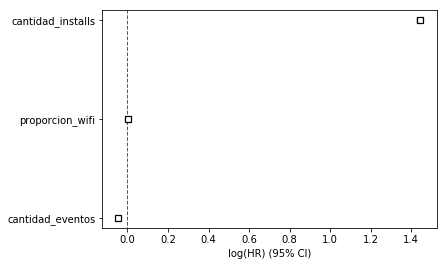

In [58]:
cphSinDuplicadosSinId.print_summary()
cphSinDuplicadosSinId.plot()

### El resultado parece bastante interesante aunque tiene un concordance_index muy alto. Tratamos ahora de fittearlo a la ventana siguiente, reducida en tamaño.

In [68]:
setDePrediccionVentanaUno = eventsInstallsVentanaDosWifiAndCantidad.drop(columns = ['date', 'installed'])

In [60]:
len(setDePrediccionVentanaUno)

509271

# Aca podemos probar con distintos tamaños, pero el fit a la ventana siguiente hizo que se moría mi kernel.

In [69]:
setDePrediccionVentanaUno = setDePrediccionVentanaUno.head(100)

In [77]:
fitModeloUnoSobreVentanaDos = cphSinDuplicadosSinId.predict_median(setDePrediccionVentanaUno)

In [78]:
fitModeloUnoSobreVentanaDos.describe()

,0.5
count,100.000000
mean,inf
std,NaN
min,inf
25%,inf
50%,inf
75%,inf
max,inf


### No es un fit que funciona, ya que nunca cruza con la mediana.

# FIN DE PRUEBAS DE COX